## ProtVec + RNN

In [1]:
import numpy as np
import pandas as pd

df = pd.read_parquet('Metal_all_20180116.snappy.parquet')
# print ('***** Data Types *****' + '\n' + str(df.dtypes) + '\n\n' + 
#        '***** Unique Ligands *****' + '\n' + str(df.ligandId.unique()))

# Extract zinc-binded, single-chained protein sequences
df_zn = df.loc[df['ligandId'] == 'ZN']
df_zn_single = df_zn.loc[df_zn['interactingChains'] == 1]
seqs = np.array(df_zn_single.sequence)
target = np.array(df_zn_single.fingerprint)
print ("Sequence length is " + str(seqs.shape[0]))

del df,df_zn,df_zn_single

Sequence length is 22823


### Get vector representation of sequences

In [2]:
import biovec

# A very simple protein sequences to fasta file conversion
def convertSeqsToFasta (seqs, filename):
    file = open(filename, 'w')
    size = seqs.shape[0]
    for i,l in zip(range(size),seqs):
        file.write('>' + str(i) + '\n')
        file.write(l + '\n') 

C:\Users\Tian\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
n_gram_size = 3
dimension = 100

In [ ]:
filename = 'all.fasta'
convertSeqsToFasta(seqs=df.sequence, filename=filename)
pv = biovec.models.ProtVec(corpus_fname=filename, n=n_gram_size, size=dimension)

In [4]:
import json

def construct_n_gram_to_vector_dict(filename, seqs, pv, n_gram_size):
    n_gram_to_vec = {}
    
    for i in range(seqs.shape[0]):
        for j in range(len(seqs[i])-(n_gram_size-1)):
            word = seqs[i][j:j+n_gram_size]
            n_gram_to_vec[word] = pv[word].tolist()
    with open(filename, 'w') as fp:
        json.dump(n_gram_to_vec, fp)  
    print ("Done")


In [77]:
# Write
construct_n_gram_to_vector_dict("seq_n_gram_to_vec_dict", seqs, pv, n_gram_size)

Done


In [4]:
# Load
seqs_dict = {}
with open("seq_n_gram_to_vec_dict", 'r') as fp:
        seqs_dict = json.load(fp)

### Construct feature vector

In [5]:
# Data from previous sections
# seqs, target, seqs_dict
# dimension

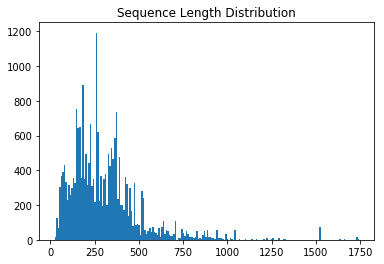

In [10]:
import matplotlib.pyplot as plt

# Plot distribution of sequence lengths
lengths = []
for item in seqs:
    lengths.append(len(item))

fig = plt.figure(0)
ax = fig.add_subplot(111)
ax.set_title('Sequence Length Distribution')
n, bins, rectangles = ax.hist(lengths, 200)
fig.canvas.draw()
plt.show()

In [6]:
def to_onehot(target_single, cutoff):
    t = [0] * cutoff
    for j in target_single:
        t[j] = 1 
    return t

def optimal_cutoff(seqs, target, cutoff):
    new_seqs = []
    new_target = []
    new_lengths = []
    for i, s, t in zip(range(seqs.shape[0]), seqs, target):
        if len(s) <= cutoff:
            new_seqs.append(s + (cutoff-len(s)) * '0')
            new_target.append(to_onehot(t,cutoff))
            new_lengths.append(len(s))
    return new_seqs, new_target, new_lengths

def to_vector(seqs_dict, seq, index, n_gram_size, dimension):
    if (index+n_gram_size) < len(seq):
        word = seq[index: index+n_gram_size]
        if '0' not in word:
            return seqs_dict[word]
    return [0] * dimension
    
def construct_X(seqs_dict, seqs, cutoff, n_gram_size, dimension, sample_size, start_index):
    X = np.zeros((sample_size, cutoff, dimension))
    # Fix this
    for i in range(sample_size):
        for j in range(cutoff):
            X[i][j] = np.array(to_vector(seqs_dict, seqs[start_index + i], j, n_gram_size, dimension))
    return X

def randomSample(X, Y):
    size = X.shape[0]
#     print (X.shape)
#     print (Y.shape)
    r = np.random.randint(size)
    retX = X[r].reshape((1, X.shape[1], X.shape[2]))
    retY = Y[r].reshape((1, Y.shape[1]))
    return (retX, retY)

def shuffleXY(X, Y):
    C = list(zip(X, Y))
    random.shuffle(C)
    X_ret, Y_ret = zip(*C)
    return X_ret, Y_ret

In [7]:
cutoff = 706
cv_ratio = 0.9
X, T, L = optimal_cutoff(seqs, target, cutoff)
X_train, X_val = X[:(int)(len(X) * cv_ratio)], X[(int)(len(X) * cv_ratio):]
T_train, T_val = T[:(int)(len(T) * cv_ratio)], T[(int)(len(T) * cv_ratio):]
print ('Training set size is ' + str(len(X_train)))

Training set size is 19612


In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import load_model

import random

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Using TensorFlow backend.


In [9]:
model = load_model('current_model_shuffled')

In [12]:
# Build Model
model = Sequential()
# model.add()
model.add(LSTM(128, input_shape=(cutoff,dimension)))
model.add(Dropout(0.2))
model.add(Dense(cutoff, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 706)               91074     
Total params: 208,322
Trainable params: 208,322
Non-trainable params: 0
_________________________________________________________________


# Updates
1. ROC Scores
2. Reduce size of input tensor
3. review of BRNN architecture

In [10]:
from sklearn.metrics import roc_auc_score

class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.roc_scores = []

    def on_train_begin(self, logs={}):
        self.roc_scores = []
        return
    def on_train_end(self, logs={}):
        return 
#     def on_epoch_begin(self, epoch, logs={}):
#         return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
#         print (self.y.shape, y_pred.shape)
        roc = roc_auc_score(self.y.ravel(), y_pred.ravel())
        y_pred_val = self.model.predict(self.x_val)
#         print (self.y_val.shape, y_pred_val.shape)

        roc_val = roc_auc_score(self.y_val.ravel(), y_pred_val.ravel())
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        self.roc_scores.append((round(roc,4), round(roc_val,4)))
        return 

#     def on_batch_begin(self, batch, logs={}):
#         return
#     def on_batch_end(self, batch, logs={}):
#         return

In [11]:
#Input (50,706,100) = 3,530,000 [141200000] 
#Output (50,706,1) = 35,300 [1412000]


history_of_loss = [] # Accumulated loss over epoch * num_of_samples / fold_size
histroy_of_roc = []
epoch =10
batch_size = 50 # Minibatch size
fold_size = 1000 # Input tensor size (fold_size, cutoff, dimension)

def training_procedure():
    
    # Shuffle batch at each epoch
    X_train_shuffled, T_train_shuffled = shuffleXY(X_train, T_train)
    X_val_shuffled, T_val_shuffled = shuffleXY(X_val, T_val)
    
    # Construct validation sets
    X_Val = construct_X(seqs_dict, X_val_shuffled, cutoff, n_gram_size, dimension, len(X_val_shuffled), 0)
    T_Val = np.array(T_val_shuffled).reshape(len(T_val_shuffled), cutoff)
    
    # 1 to n-1 folds
    n = int(len(X_train) / fold_size)
    for i in range(n):
        print('Training from [' + str(i * fold_size) + '] to [' + str((i+1) * fold_size) + ']')   
        X = construct_X(seqs_dict, X_train_shuffled, cutoff, n_gram_size, dimension, fold_size, i * fold_size)
        T = np.array(T_train_shuffled[i * fold_size: (i+1) * fold_size]).reshape(fold_size,cutoff)

#         hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0)
        cb = roc_callback((X,T), (X_Val, T_Val))
        hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0, 
                         callbacks=[cb])
        
        history_of_loss.append(hist.history['loss'])
        histroy_of_roc.extend(cb.roc_scores)


    # Last fold
    last_fold_size = len(X_train) - n * fold_size
    print('Training from [' + str(n * fold_size) + '] to [' + str(n * fold_size + last_fold_size) + ']')   

    X = construct_X(seqs_dict, X_train_shuffled, cutoff, n_gram_size, dimension, last_fold_size, n * fold_size)
    T = np.array(T_train_shuffled[n * fold_size : n * fold_size + last_fold_size]).reshape(last_fold_size,cutoff)

    cb = roc_callback((X,T), (X_Val, T_Val))
    hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0, 
                         callbacks=[cb])

    # hist = model.fit(X, T, epochs=epoch, batch_size=batch_size, verbose=1, 
    #                     callbacks=[roc_callback((X,T), (X_Val, T_Val))])
    history_of_loss.append(hist.history['loss'])
    histroy_of_roc.extend(cb.roc_scores)
for i in range(epoch):
    training_procedure()

Training from [0] to [1000]
roc-auc: 0.8364 - roc-auc_val: 0.8337                                                                                                    
Training from [1000] to [2000]
roc-auc: 0.8395 - roc-auc_val: 0.8337                                                                                                    
Training from [2000] to [3000]
roc-auc: 0.8486 - roc-auc_val: 0.8343                                                                                                    
Training from [3000] to [4000]
roc-auc: 0.8382 - roc-auc_val: 0.8343                                                                                                    
Training from [4000] to [5000]
roc-auc: 0.8361 - roc-auc_val: 0.8342                                                                                                    
Training from [5000] to [6000]
roc-auc: 0.8314 - roc-auc_val: 0.8344                                                                                          

roc-auc: 0.8355 - roc-auc_val: 0.8343                                                                                                    
Training from [10000] to [11000]
roc-auc: 0.8383 - roc-auc_val: 0.8341                                                                                                    
Training from [11000] to [12000]
roc-auc: 0.836 - roc-auc_val: 0.8341                                                                                                    
Training from [12000] to [13000]
roc-auc: 0.8366 - roc-auc_val: 0.8342                                                                                                    
Training from [13000] to [14000]
roc-auc: 0.8339 - roc-auc_val: 0.8344                                                                                                    
Training from [14000] to [15000]
roc-auc: 0.8346 - roc-auc_val: 0.8347                                                                                                    
Training

roc-auc: 0.8422 - roc-auc_val: 0.8345                                                                                                    
Training from [19000] to [19612]
roc-auc: 0.8412 - roc-auc_val: 0.8345                                                                                                    
Training from [0] to [1000]
roc-auc: 0.8377 - roc-auc_val: 0.834                                                                                                    
Training from [1000] to [2000]
roc-auc: 0.8365 - roc-auc_val: 0.8336                                                                                                    
Training from [2000] to [3000]
roc-auc: 0.8352 - roc-auc_val: 0.8336                                                                                                    
Training from [3000] to [4000]
roc-auc: 0.8405 - roc-auc_val: 0.8338                                                                                                    
Training from [4000

roc-auc: 0.8397 - roc-auc_val: 0.8342                                                                                                    
Training from [8000] to [9000]
roc-auc: 0.839 - roc-auc_val: 0.834                                                                                                    
Training from [9000] to [10000]
roc-auc: 0.8436 - roc-auc_val: 0.834                                                                                                    
Training from [10000] to [11000]
roc-auc: 0.8381 - roc-auc_val: 0.8339                                                                                                    
Training from [11000] to [12000]
roc-auc: 0.8372 - roc-auc_val: 0.8341                                                                                                    
Training from [12000] to [13000]
roc-auc: 0.8456 - roc-auc_val: 0.8342                                                                                                    
Training from

roc-auc: 0.837 - roc-auc_val: 0.8349                                                                                                    
Training from [17000] to [18000]
roc-auc: 0.8349 - roc-auc_val: 0.8348                                                                                                    
Training from [18000] to [19000]
roc-auc: 0.8397 - roc-auc_val: 0.8348                                                                                                    
Training from [19000] to [19612]
roc-auc: 0.8344 - roc-auc_val: 0.8347                                                                                                    


In [12]:
model.save("current_model_shuffled_2")

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print ('Metrics are [ ' + str(history.history.keys()) + ' ]')

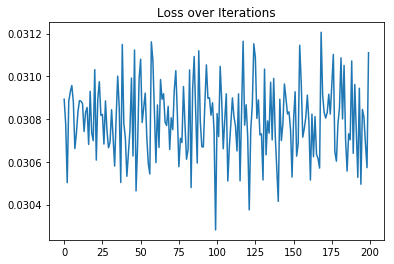

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_title('Loss over Iterations')
ax.plot(history_of_loss)
fig.canvas.draw()
plt.show()

In [14]:
X_train_shuffled, T_train_shuffled = shuffleXY(X_train, T_train)

In [37]:
X = construct_X(seqs_dict, X_train_shuffled, cutoff, n_gram_size, dimension, 2000, 0)
T = np.array(T_train_shuffled[0: 2000]).reshape(2000,cutoff)
x,y = randomSample(X, T)
output = model.predict(x)
print ('Min ', np.min(output[0]),'Max ',np.max(output[0]))

Min  2.12121e-06 Max  0.0121522


In [38]:
print (len(histroy_of_roc))

200


In [39]:
for i in range(cutoff):
    if y[0][i] == 1:
        print (i, output[0][i])

33 0.00306321
42 0.00756791
167 0.00238032


In [40]:
print (output[0][0:95])

[ 0.00087447  0.00011667  0.00040063  0.00112025  0.00126745  0.00601582
  0.00316794  0.00344922  0.00652235  0.00416091  0.00480674  0.00473537
  0.00357682  0.00408345  0.00280984  0.00468481  0.00271563  0.00620116
  0.00225771  0.00393314  0.00486532  0.00292887  0.00396936  0.00452826
  0.00508901  0.00857702  0.00703177  0.0056436   0.00770686  0.00437961
  0.00455097  0.00401255  0.00542702  0.00306321  0.00305628  0.00515052
  0.00313525  0.00333292  0.00400104  0.00549681  0.00472778  0.00375622
  0.00756791  0.00450315  0.00390725  0.00849432  0.00279029  0.00400716
  0.00298961  0.00379447  0.00475672  0.00429106  0.00317121  0.00263132
  0.00433055  0.00371842  0.0033383   0.00327842  0.00478623  0.00546165
  0.00461162  0.00409867  0.00891628  0.00476945  0.00587748  0.00517743
  0.00543378  0.00391758  0.00770623  0.0036901   0.00768225  0.00508005
  0.00435888  0.00348734  0.00299507  0.00487426  0.00511902  0.00397044
  0.0049115   0.00645018  0.00534082  0.00370144  0